In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import zipfile
import os, glob, itertools
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch
from torchvision.models import vgg19
from torchvision.utils import save_image

In [ ]:
# with zipfile.ZipFile("/content/drive/My Drive/SRGAN/Checkpoints/drive-download-20230311T015403Z-001.zip", 'r') as zObject:
#     zObject.extractall(path="/content/drive/My Drive/SRGAN/Checkpoints/")

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, paths, lr_shape, hr_shape):
        self.lr_height, self.lr_width = lr_shape
        self.hr_height, self.hr_width = hr_shape
        # Transforms for low resolution images and high resolution images
        self.lr_transform = transforms.Compose(
            [
                transforms.Resize((self.lr_height, self.lr_width), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                transforms.Resize((self.hr_height, self.hr_width), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
        self.paths = paths

    def __getitem__(self, index):
        path = self.paths[index % len(self.paths)]
        img_hr = Image.open(path)
        img_lr = Image.open("/content/drive/My Drive/SRGAN/train/DIV2K_train_LR_unknown/X2/" + path.split('/')[-1].split('.')[0] + "x2.png")
        img_lr = self.lr_transform(img_lr)
        img_hr = self.hr_transform(img_hr)

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.paths)

In [ ]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, n_features=64):
        super(ResidualBlock, self).__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=n_features, out_channels=32,
                            kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=96, out_channels=32,
                            kernel_size=3, stride=1, padding=1)
        self.conv3 = torch.nn.Conv2d(in_channels=128, out_channels=32,
                            kernel_size=3, stride=1, padding=1)
        self.conv4 = torch.nn.Conv2d(in_channels=160, out_channels=32,
                            kernel_size=3, stride=1, padding=1)
        self.conv5 = torch.nn.Conv2d(in_channels=192, out_channels=64,
                            kernel_size=3, stride=1, padding=1)

        self.leaky_relu = torch.nn.LeakyReLU(0.2, True)
        self.identity = torch.nn.Identity()

    def forward(self, x):
        x1 = self.leaky_relu(self.conv1(x))
        x2 = self.leaky_relu(self.conv2(torch.cat([x, x1],1)))
        x3 = self.leaky_relu(self.conv3(torch.cat([x, x1, x2],1)))
        x4 = self.leaky_relu(self.conv4(torch.cat([x, x1, x2, x3],1)))
        x5 = self.leaky_relu(self.conv5(torch.cat([x, x1, x2, x3, x4],1)))
        x6 = torch.mul(x5, 0.2)
        out = torch.add(x6, x)

        return out

In [ ]:
class ResidualInResidualBlock(torch.nn.Module):
    def __init__(self, n_features=64):
        super(ResidualInResidualBlock, self).__init__()

        self.rb1 = ResidualBlock(n_features=n_features)
        self.rb2 = ResidualBlock(n_features=n_features)
        self.rb3 = ResidualBlock(n_features=n_features)

    def forward(self, x):
        x1 = self.rb1(x)
        x2 = self.rb1(x1)
        x3 = self.rb1(x2)
        x4 = torch.mul(x3, 0.2)
        out = torch.add(x3, x)

        return out

In [ ]:
class Generator(torch.nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=23,
                 n_residual_features=64):
        super(Generator, self).__init__()

        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels, out_channels=n_residual_features,
                            kernel_size=9, stride=1, padding=4),
        )

        res_blocks = list()
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualInResidualBlock(n_features=n_residual_features))

        self.residual_blocks = torch.nn.Sequential(*res_blocks)

        self.conv2 = torch.nn.Conv2d(in_channels=n_residual_features, out_channels=n_residual_features,
                            kernel_size=3, stride=1, padding=1)

        self.up_sampler = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=n_residual_features, out_channels=n_residual_features,
                            kernel_size=3, stride=1, padding=1),
            torch.nn.LeakyReLU(0.2, True),
        )

        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=n_residual_features, out_channels=n_residual_features,
                            kernel_size=3, stride=1, padding=1),
            torch.nn.LeakyReLU(0.2, True),
        )

        self.conv4 = torch.nn.Conv2d(in_channels=n_residual_features, out_channels=3,
                            kernel_size=3, stride=1, padding=1)

        for module in self.modules():
            if isinstance(module, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(module.weight)
                module.weight.data *= 0.1
                if module.bias is not None:
                    torch.nn.init.constant_(module.bias, 0)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.residual_blocks(x1)
        x3 = self.conv2(x2)
        x4 = torch.add(x1, x3)
        x4 = self.up_sampler(F.interpolate(x4, scale_factor=2, mode="nearest"))
        x5 = self.conv3(x4)
        out = self.conv4(x5)

        return out

In [ ]:
class Discriminator(torch.nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.LeakyReLU(0.2, True),
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(0.2, True),
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.2, True),
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.2, True),
            torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(0.2, True),
            torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(0.2, True),
            torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.LeakyReLU(0.2, True),
            torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.LeakyReLU(0.2, True),
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(131072, 1024),
            torch.nn.LeakyReLU(0.2, True),
            torch.nn.Linear(1024, 1),
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = torch.flatten(x1, 1)
        out = self.classifier(x2)

        return out

In [ ]:
class VGGFeatureMap(torch.nn.Module):
    def __init__(self):
        super(VGGFeatureMap, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.vgg_layer = torch.nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, x):
        return self.vgg_layer(x)

In [ ]:
train_dataset_path = "/content/drive/My Drive/SRGAN/train/DIV2K_train_HR"
train_paths = glob.glob(train_dataset_path + "/*.*")
train_dataset = ImageDataset(train_paths, (128, 128), (256, 256))

In [ ]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
print(dev)
device = torch.device(dev)

cuda:0


In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
# vgg_fm = VGGFeatureMap().to(device)
generator.load_state_dict(torch.load("/content/drive/My Drive/SRGAN/Checkpoints2/generator_current.pth"))
discriminator.load_state_dict(torch.load("/content/drive/My Drive/SRGAN/Checkpoints2/discriminator_current.pth"))

<All keys matched successfully>

In [ ]:
lr_transform = transforms.Compose(
            [
                transforms.Resize((128, 96), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
img_lr = lr_transform(Image.open("/content/drive/My Drive/SRGAN/valid/DIV2K_valid_LR_unknown/X2/" + "0880" + "x2.png"))
# save_image(img_lr, '/content/drive/My Drive/SRGAN/pres.png')
inv_norm = transforms.Normalize((-1,-1,-1),(2,2,2))
input_lr = torch.unsqueeze(img_lr, dim=0)
with torch.no_grad():
    output_hr = generator(input_lr.to(device))
save_image(inv_norm(output_hr[0]), '/content/drive/My Drive/SRGAN/pres2.png')

In [ ]:
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-5)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-5)

In [ ]:
adversarial_criterion = torch.nn.BCEWithLogitsLoss().to(device)
vgg_criterion = torch.nn.MSELoss().to(device)
l1_criterion = torch.nn.L1Loss().to(device)

In [ ]:
# f = open("/content/drive/My Drive/SRGAN/Checkpoints2/logs.txt", "x")

In [ ]:
n_epochs = 200
n_epoch_start = 167
batch_size = 2

In [ ]:
for epoch in range(n_epoch_start, n_epochs+1):
    print(epoch)
    g_epoch_loss = 0
    d_epoch_loss = 0
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    for idx, imgs in enumerate(train_dataloader):
        print(idx)
        lr_input = imgs["lr"].to(device)
        hr_input = imgs["hr"].to(device)

        real_label = torch.full([batch_size, 1], 1.0, dtype=lr_input.dtype).to(device)
        fake_label = torch.full([batch_size, 1], 0.0, dtype=lr_input.dtype).to(device)

        generator.zero_grad()
        hr_generator_output = generator(lr_input)

        # .clamp(min=0.0, max=1.0)

        l1_loss = l1_criterion(hr_generator_output, hr_input)
        vgg_loss = vgg_criterion(vgg_fm(hr_generator_output), vgg_fm(hr_input).detach())
        adversarial_loss = adversarial_criterion(discriminator(hr_generator_output).clamp(min=0.0, max=1.0), real_label)
        generator_loss = l1_loss + 0.04*vgg_loss + 0.04*adversarial_loss
        # generator_loss = l1_loss + 0.006*vgg_loss
        # print(l1_loss.item(), vgg_loss.item(), adversarial_loss.item(), generator_loss.item())
        # break
        generator_loss.backward()
        g_optimizer.step()

        discriminator.zero_grad()
        discriminator_loss_real = adversarial_criterion(discriminator(hr_input).clamp(min=0.0, max=1.0), real_label)
        discriminator_loss_fake = adversarial_criterion(discriminator(hr_generator_output.detach()).clamp(min=0.0, max=1.0), fake_label)
        discriminator_loss = (discriminator_loss_fake + discriminator_loss_real)/2
        discriminator_loss.backward()
        d_optimizer.step()

        g_epoch_loss += generator_loss.item()
        d_epoch_loss += discriminator_loss.item()

        if idx % 40 == 0:
            torch.save(generator.state_dict(), "/content/drive/My Drive/SRGAN/Checkpoints2/generator_current.pth")
            torch.save(discriminator.state_dict(), "/content/drive/My Drive/SRGAN/Checkpoints2/discriminator_current.pth")

    # break
    g_epoch_loss = g_epoch_loss/400
    d_epoch_loss = d_epoch_loss/400
    # print(epoch, d_epoch_loss)
    f = open("/content/drive/My Drive/SRGAN/Checkpoints2/logs.txt", "a")
    f.write("Epoch {}: Generator Loss: {}, Discriminator Loss: {}\n".format(epoch, g_epoch_loss, d_epoch_loss))
    f.close()
    with torch.no_grad():
        valid_imgs = train_dataset[420]
        valid_input_lr = torch.unsqueeze(valid_imgs["lr"], dim=0)
        valid_output_hr = generator(valid_input_lr.to(device))
        inv_norm = transforms.Normalize((-1,-1,-1),(2,2,2))
        pred_output = inv_norm(valid_output_hr[0])
        save_image(pred_output, '/content/drive/My Drive/SRGAN/Checkpoints2/{}.png'.format(epoch))

In [ ]:
valid_imgs = train_dataset[550]
inv_norm = transforms.Normalize((-1,-1,-1),(2,2,2))
input_lr = torch.unsqueeze(valid_imgs["lr"], dim=0)
# hr = torch.unsqueeze(lr, dim=0)
with torch.no_grad():
    output_hr = generator(input_lr.to(device))

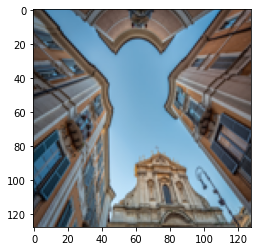

In [ ]:
plt.imshow(inv_norm(valid_imgs["lr"]).permute(1, 2, 0))

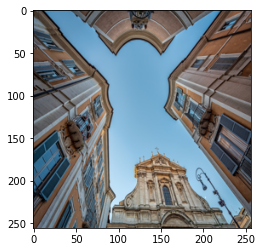

In [ ]:
plt.imshow(inv_norm(valid_imgs["hr"]).permute(1, 2, 0))

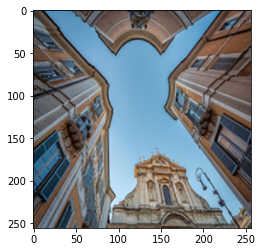

In [ ]:
plt.imshow(inv_norm(output_hr[0]).permute(1, 2, 0).cpu().detach().numpy())

In [ ]:
input_hr = torch.unsqueeze(valid_imgs["hr"], dim=0)
real_label = torch.full([1, 1], 1.0, dtype=input_lr.dtype).to(device)
fake_label = torch.full([1, 1], 0.0, dtype=input_lr.dtype).to(device)
loss_real = adversarial_criterion(discriminator(input_hr.to(device).clamp(min=0.0, max=1.0)), real_label)
loss_fake = adversarial_criterion(discriminator(output_hr).clamp(min=0.0, max=1.0), fake_label)
adv_loss = adversarial_criterion(discriminator(output_hr).clamp(min=0.0, max=1.0), real_label)
print(adv_loss, loss_real, loss_fake)

tensor(0.6931, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(8.3370, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(0.6931, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [ ]:
class ImageDataset2(Dataset):
    def __init__(self, paths, lr_shape, hr_shape):
        self.lr_height, self.lr_width = lr_shape
        self.hr_height, self.hr_width = hr_shape
        # Transforms for low resolution images and high resolution images
        self.lr_transform = transforms.Compose(
            [
                # transforms.Resize((self.lr_height, self.lr_width), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                # transforms.Resize((self.hr_height, self.hr_width), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
        self.paths = paths

    def __getitem__(self, index):
        path = self.paths[index % len(self.paths)]
        # img_hr = Image.open(path)
        # img_lr = Image.open("/content/drive/My Drive/SRGAN/valid/DIV2K_valid_LR_unknown/X2/" + path.split('/')[-1].split('.')[0] + "x2.png")
        img_lr = Image.open("/content/drive/My Drive/SRGAN/Screenshot (6).png").convert('RGB')
        img_hr = Image.open("/content/drive/My Drive/SRGAN/Screenshot (6).png").convert('RGB')
        # five_crop_lr = transforms.FiveCrop((self.lr_height, self.lr_width))
        # five_crop_hr = transforms.FiveCrop((self.hr_height, self.hr_width))
        # imgs_lr = five_crop_lr(img_lr)
        # imgs_hr = five_crop_hr(img_hr)
        # img_idx = np.random.randint(5)
        img_lr = self.lr_transform(img_lr)
        img_hr = self.hr_transform(img_hr)

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.paths)

In [ ]:
valid_dataset_path = "/content/drive/My Drive/SRGAN/valid/DIV2K_valid_HR"
valid_paths = glob.glob(valid_dataset_path + "/*.*")
valid_dataset = ImageDataset2(valid_paths, (128, 128), (256, 256))